In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Multiply, Reshape, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def cbam_block(inputs, reduction_ratio=8):
    # Channel Attention
    channel = GlobalAveragePooling1D()(inputs)
    channel = Dense(channel.shape[-1] // reduction_ratio, activation='relu')(channel)
    channel = Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = Reshape((1, inputs.shape[-1]))(channel)
    channel_out = Multiply()([inputs, channel])

    # Spatial Attention
    spatial = Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(channel_out)
    spatial_out = Multiply()([channel_out, spatial])

    return spatial_out

In [9]:
inputs = Input(shape=(n_timesteps, n_features))
x = LSTM(128, return_sequences=True)(inputs)
x = cbam_block(x)
x = LSTM(64)(x)
dense = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(dense)

lstm_cbam_model = Model(inputs, outputs)
lstm_cbam_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_cbam_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     70,656 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ lstm[0][0]        │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,064 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128)  │          0 │ lstm[0][0],       │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 1)    │        897 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 128)  │          0 │ multiply[0][0],   │
│ (Multiply)          │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │     33,280 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │      3,078 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 161,559 (631.09 KB)

 Trainable params: 161,559 (631.09 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history = lstm_cbam_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.3867 - loss: 1.4313 - val_accuracy: 0.6706 - val_loss: 0.7867
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 266ms/step - accuracy: 0.6790 - loss: 0.7190 - val_accuracy: 0.7725 - val_loss: 0.4913
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.8496 - loss: 0.3625 - val_accuracy: 0.9151 - val_loss: 0.2923
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 258ms/step - accuracy: 0.9041 - loss: 0.2501 - val_accuracy: 0.9049 - val_loss: 0.2509
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 256ms/step - accuracy: 0.9325 - loss: 0.1840 - val_accuracy: 0.9542 - val_loss: 0.1231
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.9410 - loss: 0.1540 - val_accuracy: 0.9372 - val_loss: 0.1249
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.9393 - loss: 0.1558 - val_accuracy: 0.9372 - val_loss: 0.1371
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - accuracy: 0.9467 - loss: 0

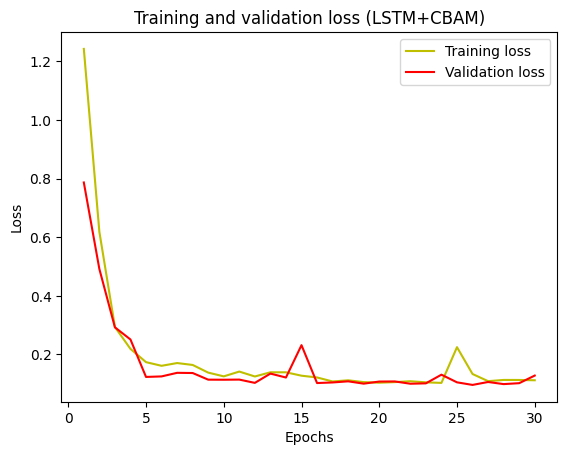

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (LSTM+CBAM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

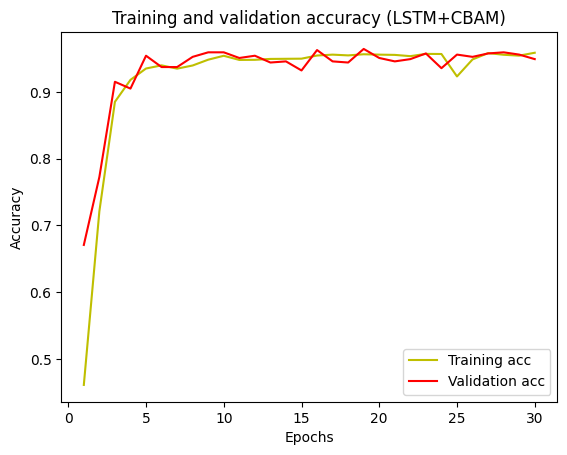

In [12]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (LSTM+CBAM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step
[[468   2  26   0   0   0]
 [  2 464   1   2   2   0]
 [  1   1 418   0   0   0]
 [  0   5   0 417  67   2]
 [  0   0   0 107 425   0]
 [  0   4   0   0   0 533]]
0.9246691550729556
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.97      0.99      0.98       471
           2       0.94      1.00      0.97       420
           3       0.79      0.85      0.82       491
           4       0.86      0.80      0.83       532
           5       1.00      0.99      0.99       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.92      0.92      2947



<Axes: >

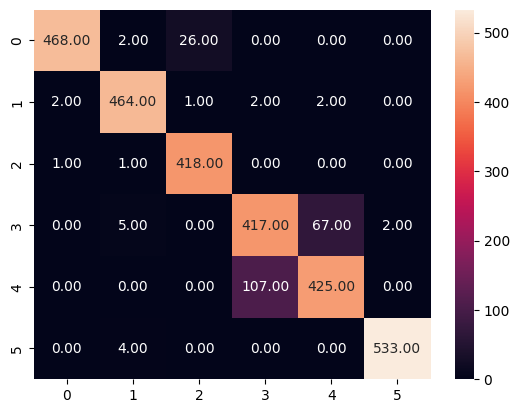

In [13]:
pred = lstm_cbam_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')